## Task 3: Transfer Learning

In [3]:
import numpy as np
from tensorflow.keras.applications import ResNet50V2
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dropout, Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import keras_tuner as kt
from keras_tuner.tuners import Hyperband
import pandas as pd

from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline, test_data_Pipeline_non_normalized
from funcs_Task3 import plot_accuracy_loss, concat_generators, plot_confusion_matrix

In [4]:
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'

epochs=30


### 1. Classification Set-Up

In [5]:
np.random.seed(123)
metrics = ["accuracy"]

### 2. Setting Up the Base Model

In [6]:
# instantiate pre-trained model and freeze layers
ResNet_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
)

ResNet_model.trainable = False

In [5]:
# add extra layers to model
inputs = Input(shape=(img_height, img_width, 3))
x = ResNet_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = keras.Model(
    inputs,
    outputs
)

# print architecture
model.summary(show_trainable = True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resnet50v2 (Functional)     │ (None, 4, 4, 2048)    │ 23,564,800 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 128)           │    262,272 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### 3. Model Training

In [8]:
# compile model and fetch training and validation data
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

train_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, test_dir = val_dir, train_dir = train_dir)

total_train=train_data_gen.samples
total_val = val_data_gen.samples

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [7]:
# train model
history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6205 - loss: 1.3171 - val_accuracy: 0.6510 - val_loss: 0.7498
Epoch 2/30
 1/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7969 - loss: 0.4778

c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.7969 - loss: 0.4778 - val_accuracy: 0.6849 - val_loss: 0.8069
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7512 - loss: 0.6516 - val_accuracy: 0.7266 - val_loss: 0.6552
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.7500 - loss: 0.5277 - val_accuracy: 0.7370 - val_loss: 0.6294
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8017 - loss: 0.4475 - val_accuracy: 0.7135 - val_loss: 0.6104
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.8125 - loss: 0.4836 - val_accuracy: 0.6589 - val_loss: 0.6286
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8081 - loss: 0.4195 - val_accuracy: 0.6771 - val_loss: 0.6114
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8125 - loss: 0.3807 - val_accuracy: 0.7057 - val_loss: 0.6065
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8167 - loss: 0.3934 - val_accuracy: 0.6901 - val_loss: 0.

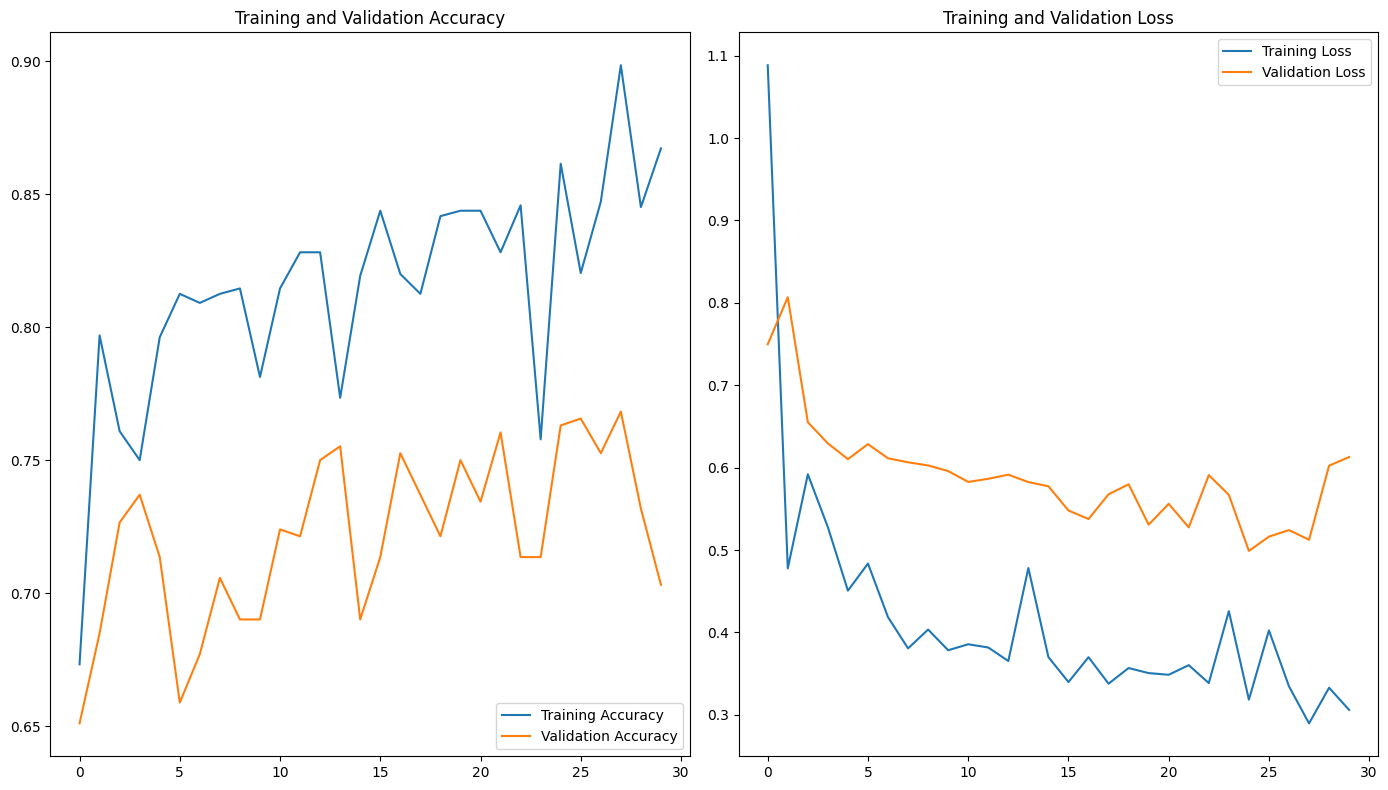

In [8]:
plot_accuracy_loss(history, epochs)

### 4. Hyperparameter Tuning

In [ ]:
# OPTION 1: Loop over different combinations of hyperparameters
# runs a very long time (>1h)

batch_sizes = [32, 64, 128]
learning_rates = [0.0001, 0.001]
dropout_rates = [0.2, 0.3, 0.4]

results = []

for batch_size in batch_sizes:
    for lr in learning_rates:
        for dr in dropout_rates:
            print(f'batch size: {batch_size}, learning rate: {lr}, dropout rate: {dr}')
            inputs = Input(shape=(img_height, img_width, 3))
            x = ResNet_model(inputs, training = False)
            x = GlobalAveragePooling2D()(x)
            x = Dense(128, activation='relu')(x)
            x = Dropout(dr)(x)
            outputs = Dense(1, activation = 'sigmoid')(x)
            model = keras.Model(
                inputs,
                outputs
            )

            optimizer = keras.optimizers.Adam(learning_rate = lr)
            model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

            # Train model
            history = model.fit(
                train_data_gen,
                batch_size=batch_size,
                steps_per_epoch=total_train // batch_size,
                epochs=epochs,
                validation_data=val_data_gen,
                validation_steps=total_val // batch_size,
                callbacks = [early_stop],
                verbose = 0
            )

            # Collect results
            best_val_acc = max(history.history['val_accuracy'])
            results.append({
                'batch_size': batch_size,
                'learning_rate': lr,
                'dropout_rate': dr,
                'val_accuracy': best_val_acc
            })

            best_val_acc = max(history.history['val_accuracy'])
            print(f"Done: batch_size={batch_size}, lr={lr}, dr={dr}, val_acc={best_val_acc:.4f}")


df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_results_task3_grid.csv", index=False)


batch size: 32, learning rate: 0.0001, dropout rate: 0.2
Done: batch_size=32, lr=0.0001, dr=0.2, val_acc=0.7917
batch size: 32, learning rate: 0.0001, dropout rate: 0.3
Done: batch_size=32, lr=0.0001, dr=0.3, val_acc=0.7839
batch size: 32, learning rate: 0.0001, dropout rate: 0.4
Done: batch_size=32, lr=0.0001, dr=0.4, val_acc=0.7734
batch size: 32, learning rate: 0.001, dropout rate: 0.2
Done: batch_size=32, lr=0.001, dr=0.2, val_acc=0.7969
batch size: 32, learning rate: 0.001, dropout rate: 0.3
Done: batch_size=32, lr=0.001, dr=0.3, val_acc=0.7943
batch size: 32, learning rate: 0.001, dropout rate: 0.4
Done: batch_size=32, lr=0.001, dr=0.4, val_acc=0.7891
batch size: 64, learning rate: 0.0001, dropout rate: 0.2
Done: batch_size=64, lr=0.0001, dr=0.2, val_acc=0.7656
batch size: 64, learning rate: 0.0001, dropout rate: 0.3
Done: batch_size=64, lr=0.0001, dr=0.3, val_acc=0.7708
batch size: 64, learning rate: 0.0001, dropout rate: 0.4
Done: batch_size=64, lr=0.0001, dr=0.4, val_acc=0.781

c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Done: batch_size=128, lr=0.0001, dr=0.2, val_acc=0.7708
batch size: 128, learning rate: 0.0001, dropout rate: 0.3
Done: batch_size=128, lr=0.0001, dr=0.3, val_acc=0.7396
batch size: 128, learning rate: 0.0001, dropout rate: 0.4
Done: batch_size=128, lr=0.0001, dr=0.4, val_acc=0.7396
batch size: 128, learning rate: 0.001, dropout rate: 0.2
Done: batch_size=128, lr=0.001, dr=0.2, val_acc=0.7500
batch size: 128, learning rate: 0.001, dropout rate: 0.3
Done: batch_size=128, lr=0.001, dr=0.3, val_acc=0.7500
batch size: 128, learning rate: 0.001, dropout rate: 0.4
Done: batch_size=128, lr=0.001, dr=0.4, val_acc=0.8333


In [ ]:
# OPTION 2: Hyperparameter tuning with keras-tuner
# runs for >2h
results = []

def build_model(hp):
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')

    inputs = Input(shape=(img_height, img_width, 3))
    x = ResNet_model(inputs, training = False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dr)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = keras.Model(
        inputs,
        outputs
    )

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

    return model


for batch_size in [32, 64, 128]:
    tuner = Hyperband(
        build_model,
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='task3_tuner_results',
        project_name=f'resnet_tuning_{batch_size}'
    )


    tuner.search(
        train_data_gen,
        batch_size=batch_size,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks = [early_stop]
    )

    best_hp = tuner.get_best_hyperparameters(1)[0]
    best_val_acc = tuner.get_best_models(1)[0].evaluate(val_data_gen, verbose=0)[1]

    results.append({
        'batch_size': batch_size,
        'learning_rate': best_hp.get('learning_rate'),
        'dropout_rate': best_hp.get('dropout_rate'),
        'val_accuracy': best_val_acc
    })

df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_results_task3_keras-tuner.csv", index=False)


Trial 30 Complete [00h 01m 52s]
val_accuracy: 0.7604166865348816

Best val_accuracy So Far: 0.8020833134651184
Total elapsed time: 00h 25m 57s


In [9]:
tf.config.run_functions_eagerly(True)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tf.config.run_functions_eagerly(False)

In [12]:
# ADD OPTIMAL PARAMETERS
batch_size = 128
learning_rate = 0.001
dropout_rate = 0.4

inputs = Input(shape=(img_height, img_width, 3))
x = ResNet_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = keras.Model(
    inputs,
    outputs
)
optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

early_history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6342 - loss: 1.0446 - val_accuracy: 0.6458 - val_loss: 0.8167
Epoch 2/30
 1/12 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6875 - loss: 0.7146

c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.6875 - loss: 0.7146 - val_accuracy: 0.6719 - val_loss: 0.7312
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7401 - loss: 0.5934 - val_accuracy: 0.6771 - val_loss: 0.5942
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 0.8359 - loss: 0.3853 - val_accuracy: 0.6693 - val_loss: 0.6072
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7612 - loss: 0.4577 - val_accuracy: 0.6745 - val_loss: 0.5964
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.7422 - loss: 0.5432 - val_accuracy: 0.7109 - val_loss: 0.5868
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7938 - loss: 0.4281 - val_accuracy: 0.7031 - val_loss: 0.5939
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8438 - loss: 0.3344 - val_accuracy: 0.7161 - val_loss: 0.5826
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8031 - loss: 0.4062 - val_accuracy: 0.6927 - val_loss: 0.

In [13]:
# Get the validation loss history
val_loss_history = early_history.history['val_loss']

# Find the epoch index with the minimum validation loss
best_epoch = np.argmin(val_loss_history)

print(f"Best epoch (0-indexed): {best_epoch}")
print(f"Best validation loss: {val_loss_history[best_epoch]}")


Best epoch (0-indexed): 16
Best validation loss: 0.5220471024513245


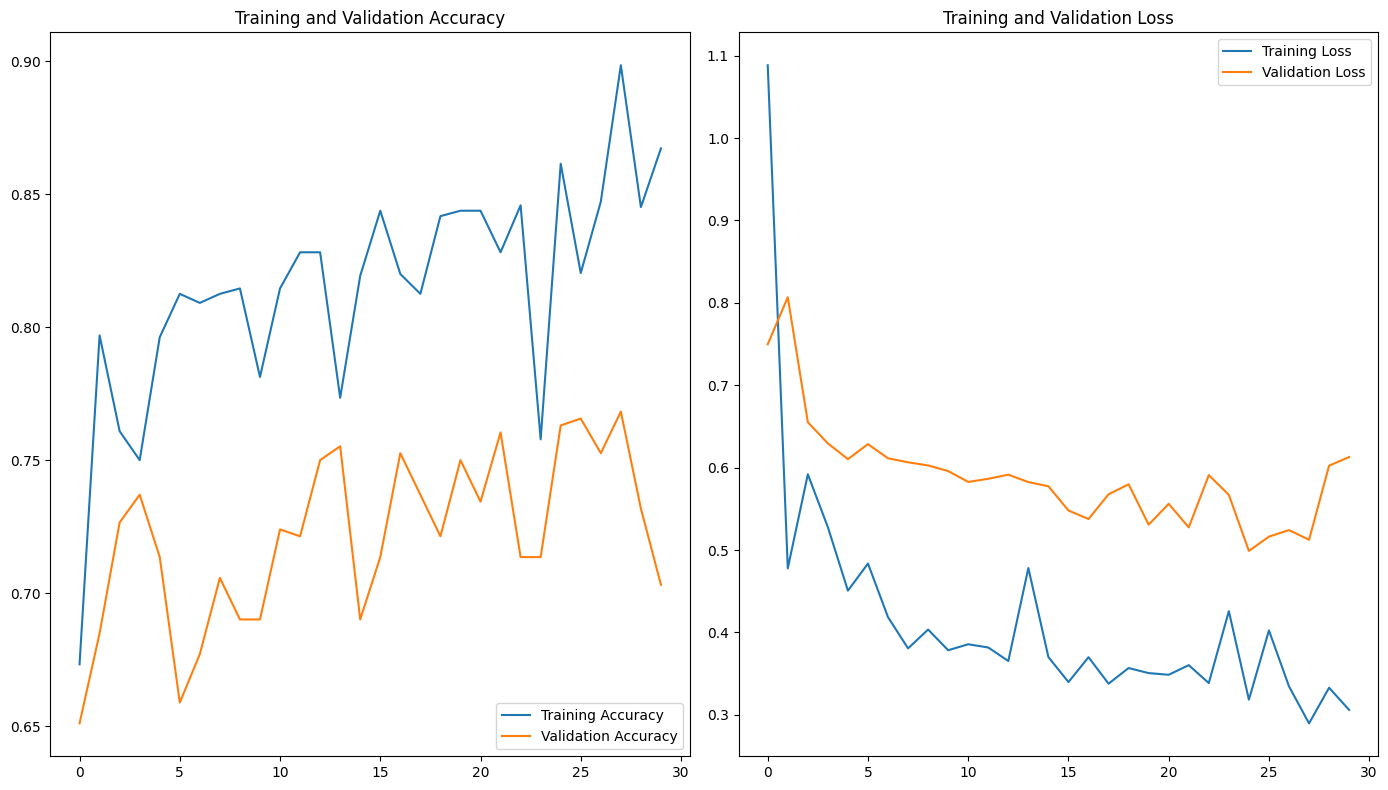

In [14]:
plot_accuracy_loss(history, epochs)

### 5. Train your pre-trained model

In [9]:
training_data_gen = training_data_Pipeline(128, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(128, img_size, train_dir, val_dir)
full_data_gen = concat_generators(training_data_gen, val_data_gen)

# ADD OPTIMAL PARAMETERS
batch_size = 128
learning_rate = 0.001
dropout_rate = 0.4
epochs = 16

inputs = Input(shape=(img_height, img_width, 3))
x = ResNet_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = keras.Model(
    inputs,
    outputs
)

optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

history = model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs
)

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5866 - loss: 2.0190
Epoch 2/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6997 - loss: 0.8126
Epoch 3/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7352 - loss: 0.5676
Epoch 4/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7731 - loss: 0.4613
Epoch 5/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7962 - loss: 0.4333
Epoch 6/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8066 - loss: 0.4101
Epoch 7/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7957 - loss: 0.4128
Epoch 8/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7908 - loss: 0.4152
Epoch 9/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7906 - loss: 0.4205
Epoch 10/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8122 - loss:

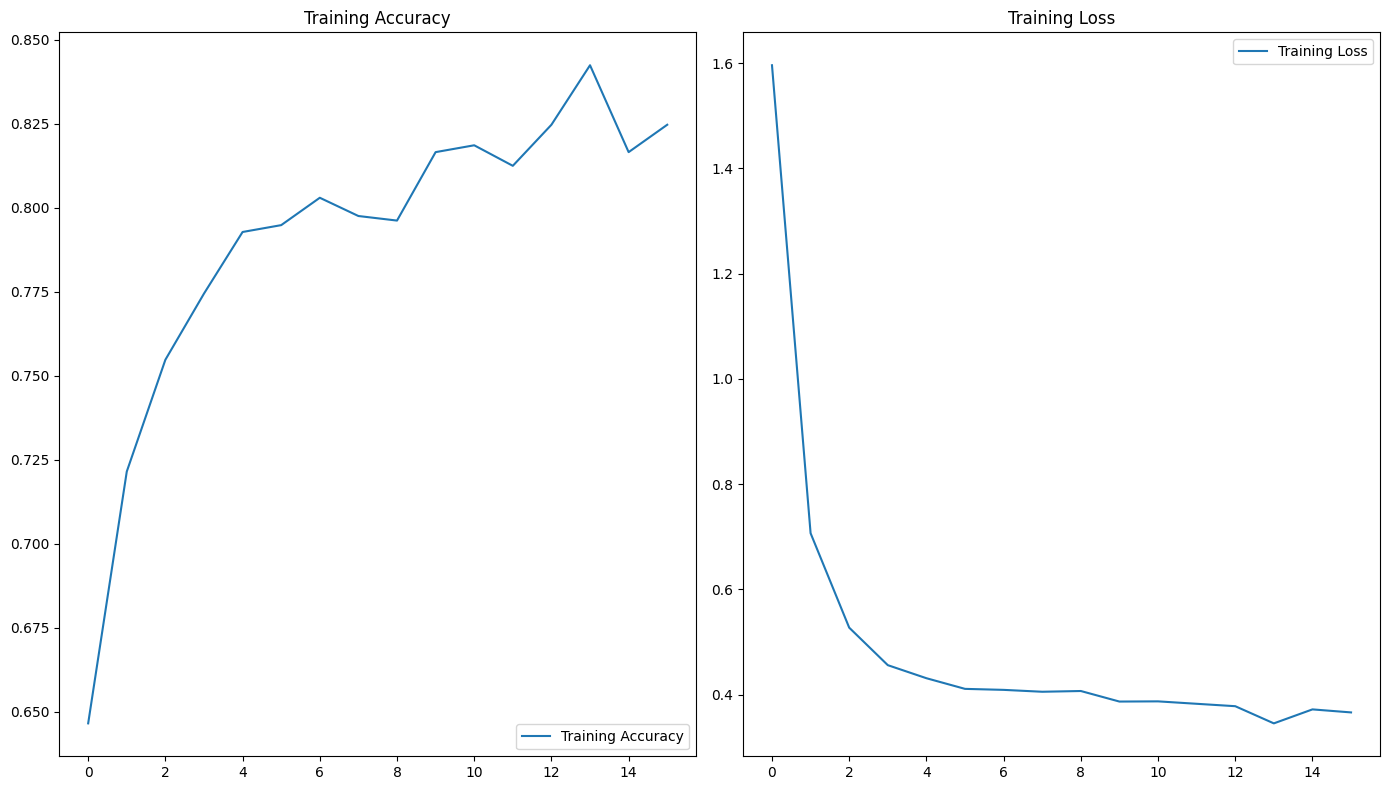

In [10]:
plot_accuracy_loss(history, epochs, validation = False)

In [11]:
model.save("ResNet_model.keras")
loaded_model = load_model("ResNet_model.keras")

### 6. Fine-tuning of the entire model

In [12]:
loaded_model.get_layer("resnet50v2").trainable = True
loaded_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics= metrics)

history = loaded_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs
)
model.save("ResNet_finetuned_model.keras")

Epoch 1/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - accuracy: 0.7636 - loss: 0.5494
Epoch 2/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - accuracy: 0.9094 - loss: 0.2126
Epoch 3/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.9358 - loss: 0.1856
Epoch 4/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - accuracy: 0.9440 - loss: 0.1648
Epoch 5/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step - accuracy: 0.9547 - loss: 0.1130
Epoch 6/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - accuracy: 0.9472 - loss: 0.1394
Epoch 7/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.9558 - loss: 0.1213
Epoch 8/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.9653 - loss: 0.0977
Epoch 9/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.9652 - loss: 0.0917
Epoch 10/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.9687 - loss: 0.0909
Epoch 11/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.9773 - loss: 0.0671
Epoch 12/16
12/12 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - accuracy: 0.9727 - lo

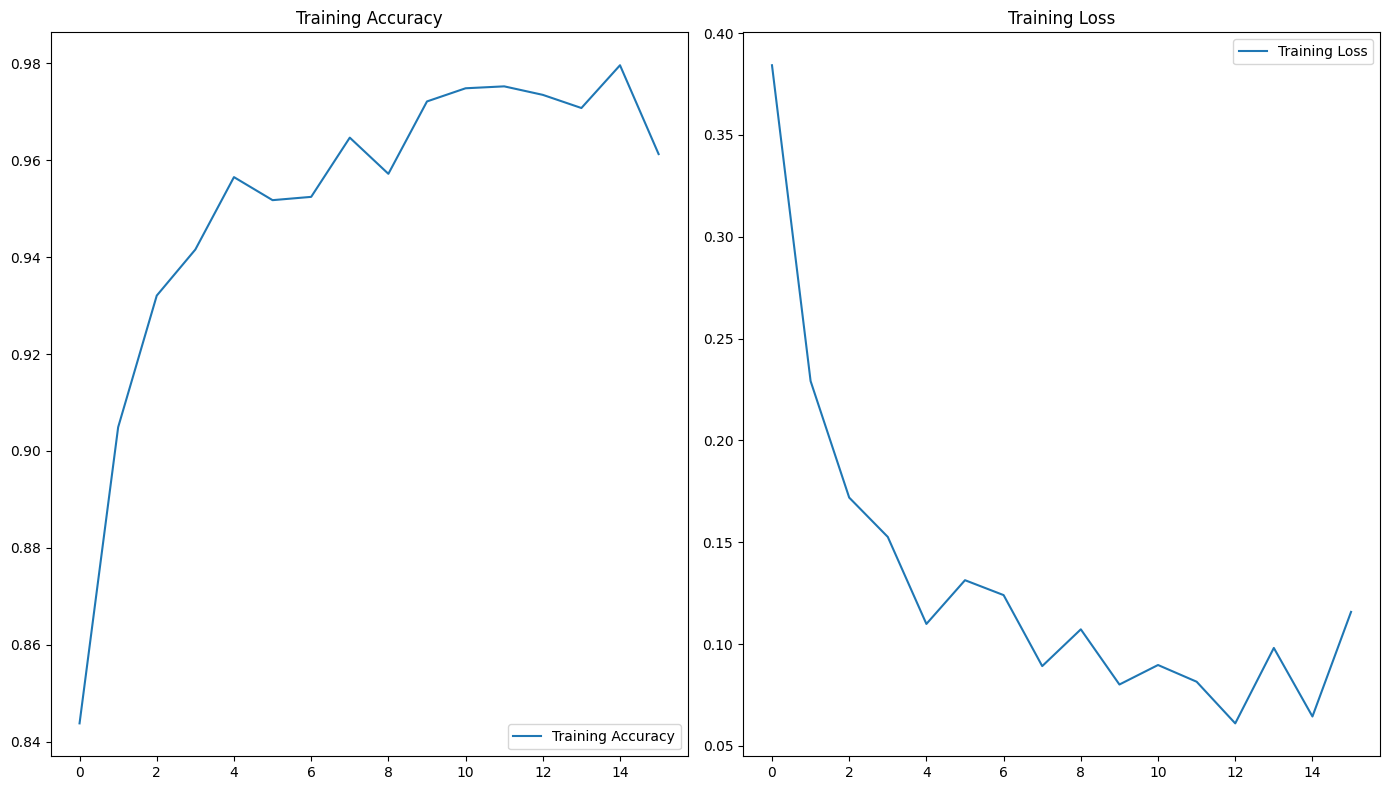

In [14]:
plot_accuracy_loss(history, epochs, validation = False)

In [15]:
final_model = load_model("ResNet_finetuned_model.keras")

In [17]:
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir)
loss, accuracy = final_model.evaluate(test_data_gen)

y_true = test_data_gen.classes
y_pred_probs = final_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_true, y_pred, target_names=test_data_gen.class_indices.keys()))

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 544ms/step - accuracy: 0.7184 - loss: 0.5254
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Test Loss: 0.5080
Test Accuracy: 0.7300
              precision    recall  f1-score   support

       COVID       0.38      0.23      0.29       100
      NORMAL       0.45      0.63      0.53       100

    accuracy                           0.43       200
   macro avg       0.42      0.43      0.41       200
weighted avg       0.42      0.43      0.41       200



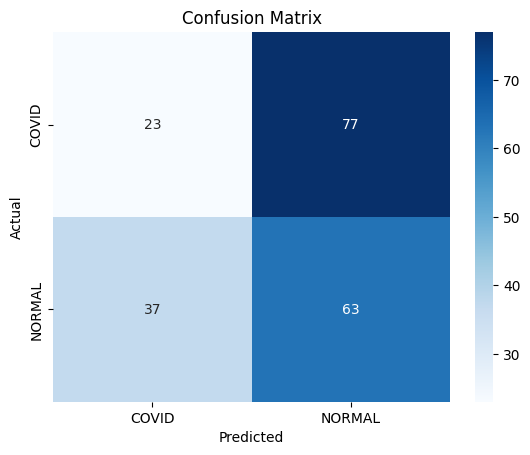

In [18]:
plot_confusion_matrix(y_true, y_pred, test_data_gen)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 531ms/step
Found 200 images belonging to 2 classes.


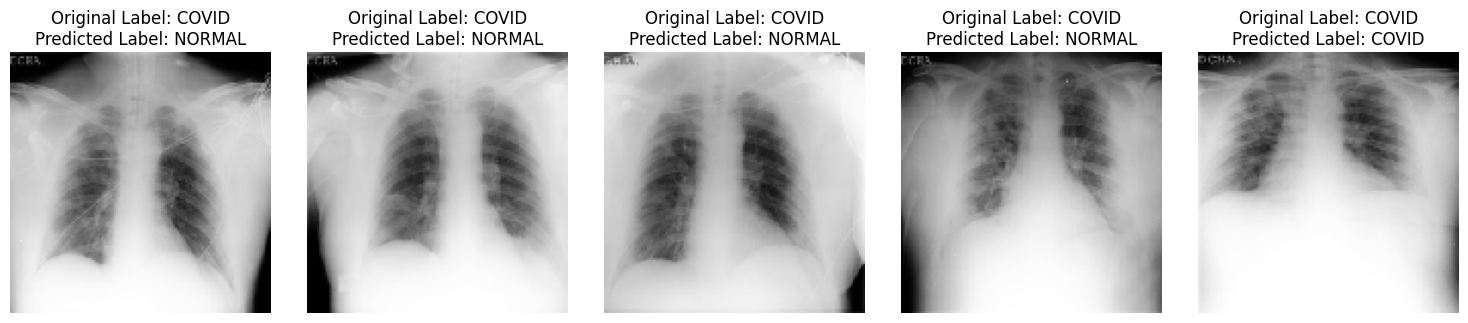

In [19]:
# Plot a few samples from the test dataset without normalization with evaluation (after normalization)

# Get batch and process
## normalized 
test_data_gen_normalized  = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir, shuffle = False)
y_pred_probs = final_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
sample_images_normalized, sample_labels_normalized  = next(test_data_gen_normalized)

## non-normalized 
test_data_gen_non_normalized = test_data_Pipeline_non_normalized(batch_size, img_size, test_dir)
sample_images_non_normalized, sample_labels_non_normalized =  next(test_data_gen_non_normalized)

class_names = list(test_data_gen.class_indices.keys())

plt.figure(figsize=(15, 6))
for i, (img, label, pred) in enumerate(zip(sample_images_non_normalized[:5], sample_labels_non_normalized[:5], y_pred[:5])):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Label: {class_names[int(label)]}\nPredicted Label: {class_names[pred]}"), plt.axis('off')
    
plt.tight_layout()
plt.show()